In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

import harmonica as hm
import verde as vd
from skimage import data, img_as_float

import skimage.exposure

from skimage.filters import rank

import micromag as mg
import time

## Declare functions

In [2]:
def random_directions(
    inclination, declination, dispersion_angle, size, random_state=None
):
    r"""
    Creates random directions around a preferred direction.

    Parameters
    ----------
    inclination : float
        Inclination of the preferred direction in degrees.
    declination : float
        Declination of the preferred direction in degrees.
    dispersion_angle : float
        Dispersion angle that defines a region on the surface of a sphere.
        Also corresponds to the variance of the generated directions.
    size : int
        Number of random directions to be generated.
    random_state : numpy.random.RandomState or an int seed
        A random number generator used to define the state of the random
        permutations. Use a fixed seed to make sure computations are
        reproducible. Use ``None`` to choose a seed automatically (resulting in
        different numbers with each run).

    Returns
    -------
    inclination : numpy.array
        Inclination of the generated directions in degrees.
    declination : numpy.array
        Declination of the generated directions in degrees.

    Notes
    -----
    We calculate the azimuth (\alpha) via a random uniform distribution
    ranging from 0° to 360°, to represent the equal probability for each
    value in a stereographic polar projection.
    The distance to the pole (\psi) for each vector is obtained with a normal
    distribution.
    Given the values of azimuth (\alpha) and distance to the pole (\psi), we
    calculate the catesian coordinates

    .. math::
        x = \sin(\psi) * cos(\alpha)
    .. math::
        y = np.sin(\psi) * sin(\alpha)
    .. math::
        z = np.cos(\psi)

    The rotation of the pole is performed to the preferred direction using the
    specified values of inclination and declination to obtain the rotation
    vector. With :math:`\theta=90°+inclination` and
    :math:`\phi=90°-declination` we calculate the rotation
    vector by

    .. math::
        \mathbf{u}=\begin{bmatrix}
        x\\y\\z
        \end{bmatrix}\\
    .. math::
        \mathbf{R}_z(\phi)\mathbf{R}_y(\theta)\mathbf{u}=\begin{bmatrix}
        \cos(\theta)&0&\sin(\theta)\\
        0&1&0\\
        -\sin(\theta)&0&\cos(\cos)
        \end{bmatrix}\begin{bmatrix}
        \cos(\phi)&-\sin(\phi)&0\\
        \sin(\phi)&\cos(\phi)&0\\
        0&0&1
        \end{bmatrix}\begin{bmatrix}
        x\\y\\z
        \end{bmatrix}\\
    .. math::

        \mathbf{R}_z(\phi) \mathbf{R}_y(\theta)\mathbf{u}  =   \begin{bmatrix}
        \cos(\phi)(X\cos(\theta)+Z\sin(\theta))-Y\sin(\phi) \\
        \sin(\phi)(X\cos(\theta)+Z\sin(\theta))+Y\cos(\phi) \\
        -X\sin(\theta)+Z\cos(\theta)
        \end{bmatrix}

    in which :math:`\mathbf{R}_z(\phi)` and :math:`\mathbf{R}_z(\phi)` are the
    rotation matrices on the z and y axes, respctively.
    """
    # Set random number generator
    rng = np.random.default_rng(random_state)

    azimuth = np.deg2rad(rng.uniform(0, 360, size))
    distance = rng.normal(0, np.deg2rad(dispersion_angle), size)
    x = np.sin(distance) * np.cos(azimuth)
    y = np.sin(distance) * np.sin(azimuth)
    z = np.cos(distance)

    x_r, y_r, z_r = _rotate_vector(x, y, z, inclination, declination)

    _, directions_inclination, directions_declination = hm.magnetic_vec_to_angles(
        x_r, y_r, z_r
    )
    return directions_inclination, directions_declination


def _rotate_vector(x, y, z, inclination, declination):
    """
    Rotates vectors using its cartesian coordines towards specific direction.

    Parameters
    ----------
    inclination : float
        Inclination of the preferred direction in degrees.
    declination : float
        Declination of the preferred direction in degrees.
    x : numpy.array
        x coordinates of vectors to be rotated.
    y : numpy.array
        y coordinates of vectors to be rotated.
    z : numpy.array
        z coordinates of vectors to be rotated.

    Returns
    -------
    x_r : numpy.array
        x coordinates of rotated vectors.
    y_r : numpy.array
        y coordinates of rotated vectors.
    z_r : numpy.array
        z coordinates of rotated vectors.
    """

    theta = np.deg2rad(90 + inclination)
    phi = np.deg2rad(90 - declination)
    # R_z(phi)*R_y(theta)
    x_r = np.cos(phi) * (x * np.cos(theta) + z * np.sin(theta)) - y * np.sin(phi)
    y_r = np.sin(phi) * (x * np.cos(theta) + z * np.sin(theta)) + y * np.cos(phi)
    z_r = -x * np.sin(theta) + z * np.cos(theta)
    return x_r, y_r, z_r
def generate_grid(region, spacing, sensor_sample_distance, dipole_coordinates, amplitude, inclination, declination, field):
    """
    Creates a regular grid of observation points.

    Parameters
    ----------
    region: list
        The boundaries of a given region in Cartesian coordinates in µm.
    spacing : float, tuple = (s_north, s_east), or None
    
    sensor_sample_distance : float
        µm

    Returns
    -------
    grid_coordinates :

    """
    grid_coordinates = vd.grid_coordinates(
        region=region,
        spacing=spacing,
        extra_coords=sensor_sample_distance,
    )

    x, y, z = hm.magnetic_angles_to_vec(
    amplitude, inclination, declination
    )
    
    dipole_moments = (x,y,z)

    # Coordinates are multiplied by 1.0E-6 to fix scale
    bz = hm.dipole_magnetic(np.asarray(grid_coordinates)*1.0E-6, np.asarray(dipole_coordinates)*1.0E-6, dipole_moments, field)
    
    data = vd.make_xarray_grid(grid_coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
    data.x.attrs = {"units": "µm"}
    data.y.attrs = {"units": "µm"}
    data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
    
    return data

def amplitude_lognormal_distribution(size, mean=0, sigma=1.35, scale=1E-14):
    r"""
    Generate amplitude values in a lognormal distribution.

    Parameters
    ----------
    mean : float or array_like of floats, optional
        Mean value of the underlying normal distribution. Default is 0.

    sigma : float or array_like of floats, optional
        Standard deviation of the underlying normal distribution. Must be
        non-negative. Default is 1.

    size : int
        Number of values to be generated.

    Returns
    -------
    amplitude : ndarray or scalar
        Samples drawn from the parameterized log-normal distribution,
        representing random amplitude values. The output array is scaled
        to represent values in nT (nanoteslas).
    """
    lognormal_distribution = np.random.lognormal(mean, sigma, size)
    amplitude = lognormal_distribution * scale
    return amplitude

def random_coordinates(sources_region, number_of_sources, seed=5):
    """
    Generate random coordinates within a specified region.

    Parameters:
    sources_region: list 
        A list containing the limits for x, y, and z coordinates. 
        Format: [x_min, x_max, y_min, y_max, z_min, z_max]
    number_of_sources: list 
        Number of sources for which coordinates will be generated. 
        Format: [n_sources_0, n_sources_1, ..., n_sources_n]
    seed: int 
        Seed value for reproducible random number generation. Default is 5.

    Returns:
        numpy.ndarray: An array of shape (3, number_of_sources) containing the generated
        coordinates. The first row represents x coordinates, the second row represents
        y coordinates, and the third row represents z coordinates.
    """
    np.random.seed(seed)
    coordinates = (
        np.random.randint(sources_region[0], sources_region[1], number_of_sources),
        np.random.randint(sources_region[2], sources_region[3], number_of_sources),
        np.random.randint(sources_region[4], sources_region[5], number_of_sources)
    )
    return np.asarray(coordinates)


def data_gradients(data):
    """
    Add the derivatives and total gradient amplitude
    """
    dx = data.differentiate("x")
    dy = data.differentiate("y")
    spacing = np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])
    # Need to set the exact same coordinates because the xrft inverse transform
    # creates slightly different ones because of round-off errors.
    data_up = hm.upward_continuation(data, spacing).assign_coords(
        dict(x=data.x, y=data.y)
    )
    data_down = hm.upward_continuation(data, -spacing).assign_coords(
        dict(x=data.x, y=data.y)
    )
    # Forward difference only to avoid downward continuation.
    dz = (data_up - data_down) / (2 * spacing)
    tga = np.sqrt(dx**2 + dy**2 + dz**2)
    tga.attrs = {"long_name": "total gradient amplitude", "units": "nT/µm"}
    dx.attrs = {"long_name": "x-derivative", "units": "nT/µm"}
    dy.attrs = {"long_name": "y-derivative", "units": "nT/µm"}
    dz.attrs = {"long_name": "z-derivative", "units": "nT/µm"}
    return xr.Dataset({"tga": tga, "x_deriv": dx, "y_deriv": dy, "z_deriv": dz})

def detection_stats(windows, coordinates):
    x = coordinates[0]
    y = coordinates[1]

    sources_inside_list = list()
    for window in windows:
        sources_inside = 0
        for i in range(len(x)):
            if (window[0] <= x[i] <= window[1]) and (window[2] <= y[i] <= window[3]):
                sources_inside += 1
        sources_inside_list.append(sources_inside)

    unique , counts = np.unique(sources_inside_list, return_counts=True)

    print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds')

    for i in range(len(unique)):
        if unique[i] == 1:
            print(f'{counts[i]} windows containing 1 source')
        else:
            print(f'{counts[i]} windows containing {unique[i]} sources')


## Generating synthetic


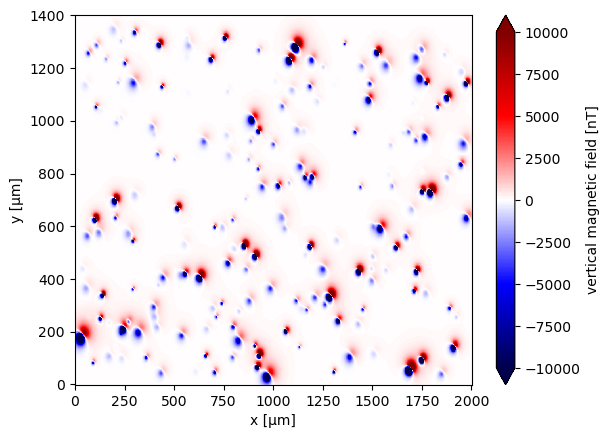

In [3]:
region=[0, 2000, 0, 1400]
spacing = 2
sensor_sample_distance = 5

number_of_sources = 200
sources_region = [30,1990,30,    1370,-20,-1]
seed = 5

coordinates = random_coordinates(sources_region, number_of_sources, seed)
amplitude = amplitude_lognormal_distribution(number_of_sources, scale=1e-13)


true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

directions_inclination, directions_declination = random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=number_of_sources,
    random_state=5,
)

field = "b_u"
data = generate_grid(region, spacing, sensor_sample_distance, coordinates, amplitude, directions_inclination, directions_declination, field)

scale=10000
data.bz.plot.pcolormesh(cmap="seismic", vmin=-scale, vmax=scale)


### Add some noise

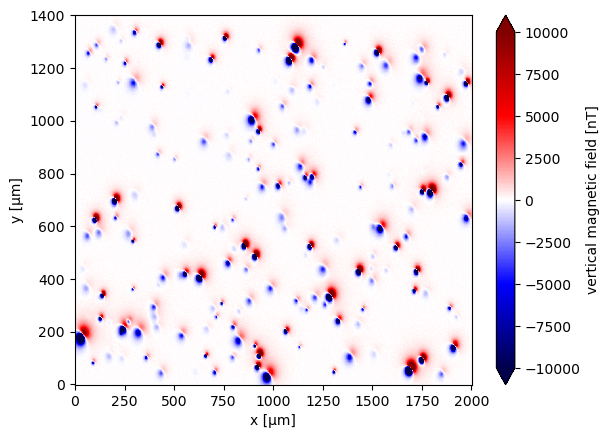

In [4]:
rng = np.random.default_rng(seed)
noise_std_dev = 50  # nT
noise = rng.normal(loc=0, scale=noise_std_dev, size=data.bz.shape)
data.bz.values += noise

scale=10000
data.bz.plot.pcolormesh(cmap="seismic", vmin=-scale, vmax=scale)

## Upward continue the data to suppress the high-frequency noise

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 11MB
Dimensions:  (y: 701, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 6kB 0.0 2.0 4.0 6.0 ... 1.396e+03 1.398e+03 1.4e+03
    z        (y, x) float64 6MB 9.0 9.0 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0 9.0
Data variables:
    bz       (y, x) float64 6MB 4.183 6.127 9.89 12.24 ... 7.623 3.507 1.786


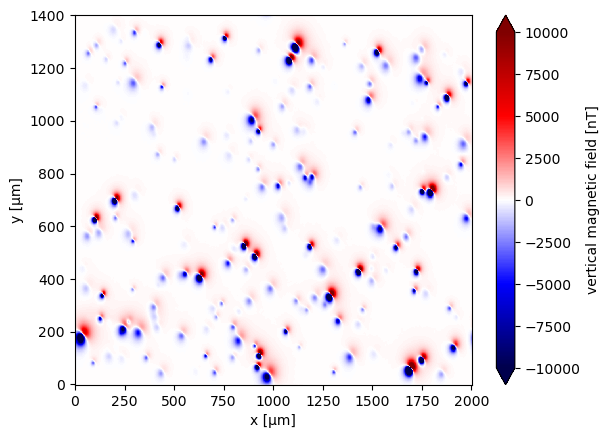

In [5]:
height_difference = 4

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
print(data_up)


data_up.bz.plot.pcolormesh(cmap="seismic", vmin=-scale, vmax=scale)

In [6]:
data = data.assign(upward_bz = data_up.bz)
data


<xarray.Dataset> Size: 17MB
Dimensions:    (y: 701, x: 1001)
Coordinates:
  * x          (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y          (y) float64 6kB 0.0 2.0 4.0 6.0 ... 1.396e+03 1.398e+03 1.4e+03
    z          (y, x) float64 6MB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz         (y, x) float64 6MB -24.55 -50.49 3.499 ... -66.48 -68.92 -46.25
    upward_bz  (y, x) float64 6MB 4.183 6.127 9.89 12.24 ... 7.623 3.507 1.786

### Calculate TGA

In [7]:
data = data.assign(data_gradients(data.upward_bz))


/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


### Stretch TGA intensity

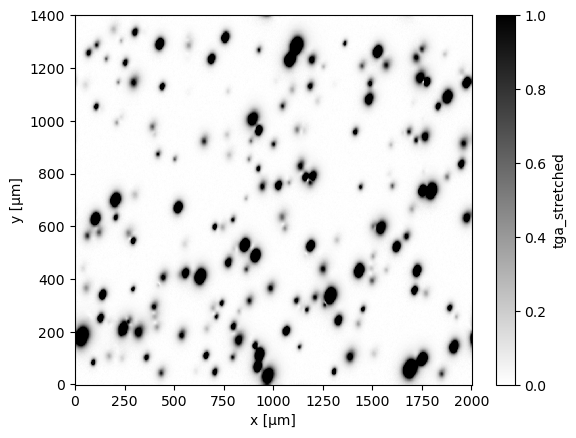

In [30]:
stretched = skimage.exposure.rescale_intensity(
    data.tga, 
    in_range=tuple(np.percentile(data.tga, (0.1, 97))),
)
data = data.assign(tga_stretched=xr.DataArray(stretched, coords=data.coords))
data.tga_stretched.plot.pcolormesh(cmap="gray_r")

### Detect sources

119 potential sources detected within 21.6256 seconds
102 windows containing 1 source
13 windows containing 2 sources
2 windows containing 3 sources
2 windows containing 4 sources
119 potential sources detected within 21.6256 seconds


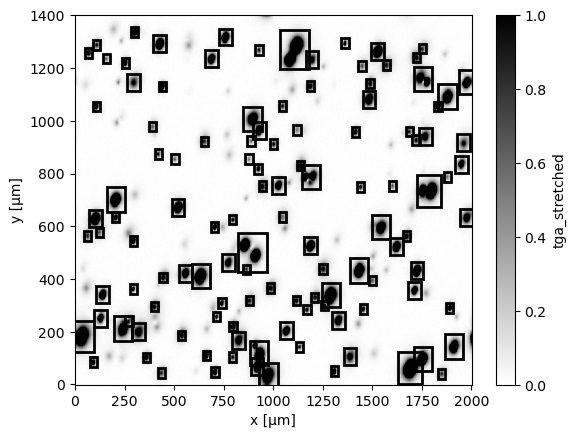

In [31]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data.tga_stretched,
    size_range=[20, 155],
    size_increment=1.3,
    threshold=0.2,
    overlap=0.3,
    exclude_border=15
)
# windows

end_detection_time = time.perf_counter()

detection_time = end_detection_time-start_detection_time

detection_stats(windows, coordinates)
print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )
ax = plt.subplot(111)
data.tga_stretched.plot.pcolormesh(cmap="gray_r")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)    

119 potential sources detected within 21.6256 seconds
102 windows containing 1 source
13 windows containing 2 sources
2 windows containing 3 sources
2 windows containing 4 sources


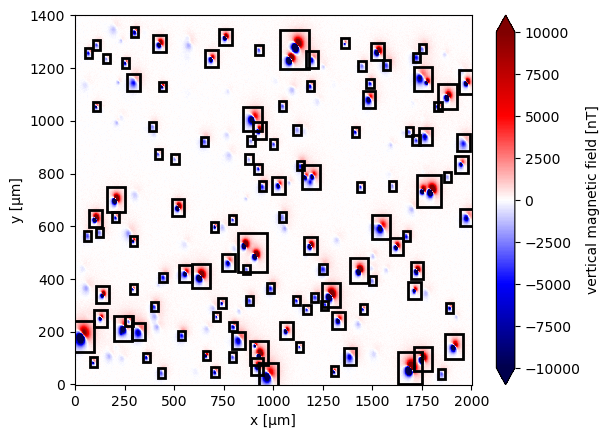

In [32]:
detection_stats(windows, coordinates)
ax = plt.subplot(111)
data.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

## Add data 

In [33]:
region=[0, 2000, 0, 1400]
spacing = 2
sensor_sample_distance = 5

number_of_sources = 100
sources_region = [30,1990,30,    1370,-20,-1]
seed = 6

new_coordinates = random_coordinates(sources_region, number_of_sources, seed)
new_amplitude = amplitude_lognormal_distribution(number_of_sources, scale=1e-13)


true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

new_directions_inclination, new_directions_declination = random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=number_of_sources,
    random_state=5,
) 

In [21]:
x_coordinates = np.append(coordinates[0], new_coordinates[0])
y_coordinates = np.append(coordinates[1], new_coordinates[1])
z_coordinates = np.append(coordinates[2], new_coordinates[2])

coordinates_joined = np.array([x_coordinates,y_coordinates,z_coordinates])

amplitude_joined = np.append(amplitude, new_amplitude)

directions_inclination_joined = np.append(directions_inclination, new_directions_inclination)
directions_declination_joined = np.append(directions_declination, new_directions_declination)

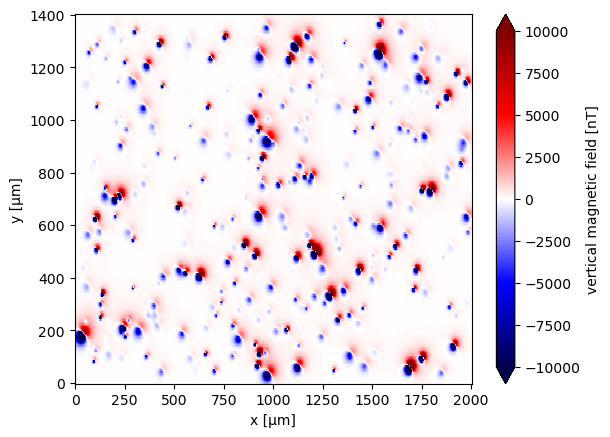

In [22]:
field = "b_u"
new_data = generate_grid(region, spacing, sensor_sample_distance, coordinates_joined, amplitude_joined, directions_inclination_joined, directions_declination_joined, field)
scale=10000
new_data.bz.plot.pcolormesh(cmap="seismic", vmin=-scale, vmax=scale)

NameError: name 'bz' is not defined

In [ ]:
print(len(data.z))
print(len(new_data.z))
print(len(data.bz))
print(len(new_data.bz))

701
281
701
281


data.z

In [ ]:
a = new_data.y + data.y
print(len(data.y))
print(len(new_data.y))
print(len(a.y))
print(len(data.bz))
print(len(new_data.bz))

701
281
141
701
281


In [ ]:
x = np.append(data.x.values, new_data.x.values)
y = np.append(data.y.values, new_data.y.values)
z = np.append(data.z.values, new_data.z.values)


ValueError: conflicting sizes for dimension 'x': length 1402 on 'x' and length 1001 on {'y': 'bz', 'x': 'bz'}

## Adding more sources

In [ ]:
x = np.append(coordinates[0], new_coordinates[0])
y = np.append(coordinates[1], new_coordinates[1])
z = np.append(coordinates[2], new_coordinates[2])

a = np.asarray([x,y,z])
a[0]

array([ 897,  236, 1755, 1028, 1172, 1454,  103, 1062,  770, 1797,  441,
        654,  700, 1774, 1573,  234, 1965, 1167, 1491, 1134,   57, 1098,
        235, 1769, 1119, 1485, 1596, 1140, 1691,  176, 1308,  407, 1703,
       1416,   71, 1500, 1951,  240,  133, 1198, 1004,   35, 1880,  798,
        930, 1164,  706, 1927, 1745,  569,  829,  800,  354,  324, 1159,
        177,  304,  911,  275, 1189,  898,  394, 1675, 1724,  220, 1833,
       1545,  865, 1434, 1503,  213,  417,  633,  108, 1977, 1979,  831,
        759,  883,  421,  558, 1148,   44, 1016, 1853,  295, 1604, 1869,
        174, 1443,  448,  715, 1753,  438, 1451,  404, 1289,  774,   61,
       1086,  362, 1226, 1955,  428,  205,  124,  880,  926, 1189, 1268,
        558, 1118,  294, 1528,   74,  668,  707,  124, 1513,  931,  775,
        948,  210,  867, 1776, 1754, 1913, 1083,  246,  662,  255,  506,
        749, 1892,  577,  909,  306,  207,  541,  614, 1726, 1264, 1067,
       1274,  537,  781, 1200, 1362, 1391, 1076, 18

In [ ]:
a = data.merge(data, new_data)
len(a.bz)

TypeError: Dataset.update() takes 2 positional arguments but 3 were given

In [ ]:

data.bz.values += new_data.bz.

data.bz.plot.pcolormesh(cmap="seismic", vmin=-scale, vmax=scale)


SyntaxError: invalid syntax (1477601702.py, line 1)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 11MB
Dimensions:  (y: 701, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 6kB 0.0 2.0 4.0 6.0 ... 1.396e+03 1.398e+03 1.4e+03
    z        (y, x) float64 6MB 9.0 9.0 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0 9.0
Data variables:
    bz       (y, x) float64 6MB 4.183 6.127 9.89 12.24 ... 7.623 3.507 1.786


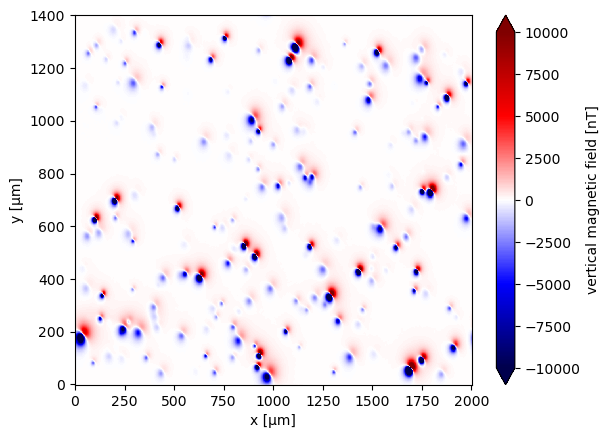

In [ ]:
height_difference = 4

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
print(data_up)


data_up.bz.plot.pcolormesh(cmap="seismic", vmin=-scale, vmax=scale)

In [ ]:
data = data.assign(data_gradients(data.bz))


/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


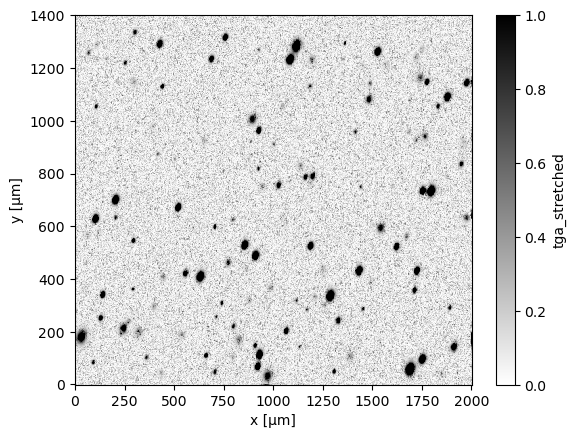

In [ ]:
stretched = skimage.exposure.rescale_intensity(
    data.tga, 
    in_range=tuple(np.percentile(data.tga, (0.1, 99))),
)
data = data.assign(tga_stretched=xr.DataArray(stretched, coords=data.coords))
data.tga_stretched.plot.pcolormesh(cmap="gray_r")

### Updating coordinates

In [ ]:
coordinates[0]

array([ 897,  236, 1755, 1028, 1172, 1454,  103, 1062,  770, 1797,  441,
        654,  700, 1774, 1573,  234, 1965, 1167, 1491, 1134,   57, 1098,
        235, 1769, 1119, 1485, 1596, 1140, 1691,  176, 1308,  407, 1703,
       1416,   71, 1500, 1951,  240,  133, 1198, 1004,   35, 1880,  798,
        930, 1164,  706, 1927, 1745,  569,  829,  800,  354,  324, 1159,
        177,  304,  911,  275, 1189,  898,  394, 1675, 1724,  220, 1833,
       1545,  865, 1434, 1503,  213,  417,  633,  108, 1977, 1979,  831,
        759,  883,  421,  558, 1148,   44, 1016, 1853,  295, 1604, 1869,
        174, 1443,  448,  715, 1753,  438, 1451,  404, 1289,  774,   61,
       1086,  362, 1226, 1955,  428,  205,  124,  880,  926, 1189, 1268,
        558, 1118,  294, 1528,   74,  668,  707,  124, 1513,  931,  775,
        948,  210,  867, 1776, 1754, 1913, 1083,  246,  662,  255,  506,
        749, 1892,  577,  909,  306,  207,  541,  614, 1726, 1264, 1067,
       1274,  537,  781, 1200, 1362, 1391, 1076, 18

In [ ]:
new_coordinates[0]

array([1928, 1718, 1303, 1697,  982,  998,  286,  819, 1051,  689, 1768,
        905, 1047, 1735, 1704,  947, 1173, 1476,  510, 1714,  635, 1477,
        428, 1558, 1592,  367, 1528,  692,  864,  288, 1370,  671,  888,
       1635,  902,  652, 1663,  443, 1672, 1206,  537,  860,  549, 1046,
       1225, 1599,  409, 1389,  206, 1859])

In [ ]:
for i in range(len(new_coordinates[0])):
    x = np.append(new_coordinates[0][i], coordinates[0])
    y = np.append(new_coordinates[1][i], coordinates[1])
    z = np.append(new_coordinates[2][i], coordinates[2])

    coordinates

In [ ]:
x = np.append(coordinates[0], new_coordinates[0])
y = np.append(coordinates[1], new_coordinates[1])
z = np.append(coordinates[2], new_coordinates[2])

coordinates = np.asarray([x,y,z])
coordinates[0]

array([ 897,  236, 1755, 1028, 1172, 1454,  103, 1062,  770, 1797,  441,
        654,  700, 1774, 1573,  234, 1965, 1167, 1491, 1134,   57, 1098,
        235, 1769, 1119, 1485, 1596, 1140, 1691,  176, 1308,  407, 1703,
       1416,   71, 1500, 1951,  240,  133, 1198, 1004,   35, 1880,  798,
        930, 1164,  706, 1927, 1745,  569,  829,  800,  354,  324, 1159,
        177,  304,  911,  275, 1189,  898,  394, 1675, 1724,  220, 1833,
       1545,  865, 1434, 1503,  213,  417,  633,  108, 1977, 1979,  831,
        759,  883,  421,  558, 1148,   44, 1016, 1853,  295, 1604, 1869,
        174, 1443,  448,  715, 1753,  438, 1451,  404, 1289,  774,   61,
       1086,  362, 1226, 1955,  428,  205,  124,  880,  926, 1189, 1268,
        558, 1118,  294, 1528,   74,  668,  707,  124, 1513,  931,  775,
        948,  210,  867, 1776, 1754, 1913, 1083,  246,  662,  255,  506,
        749, 1892,  577,  909,  306,  207,  541,  614, 1726, 1264, 1067,
       1274,  537,  781, 1200, 1362, 1391, 1076, 18

In [ ]:
a = list(coordinates[0]).append(0)
type(a)

NoneType

84 potential sources detected within 4.502 seconds
74 windows containing 1 source
3 windows containing 2 sources
7 windows containing 3 sources
84 potential sources detected within 4.502 seconds


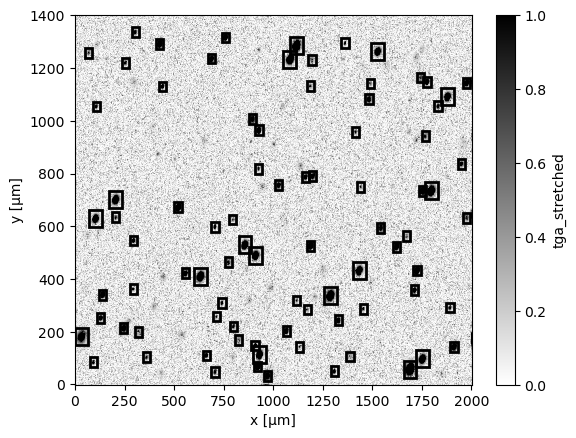

In [ ]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data.tga_stretched,
    size_range=[20, 155],
    size_increment=1.3,
    threshold=0.2,
    overlap=0.3,
    exclude_border=15
)
# windows

end_detection_time = time.perf_counter()

detection_time = end_detection_time-start_detection_time

detection_stats(windows, coordinates)
print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )
ax = plt.subplot(111)
data.tga_stretched.plot.pcolormesh(cmap="gray_r")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)    


84 potential sources detected within 4.502 seconds
74 windows containing 1 source
3 windows containing 2 sources
7 windows containing 3 sources


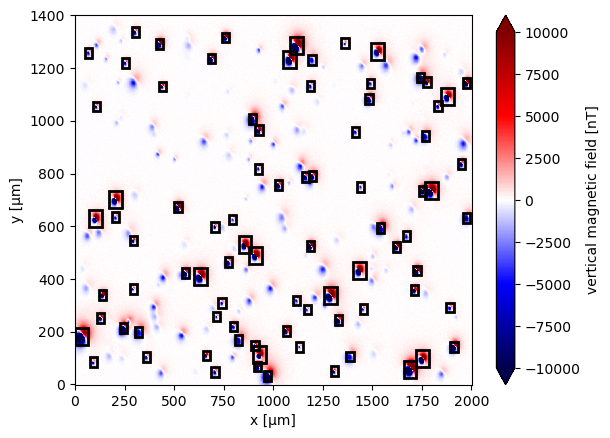

In [ ]:
detection_stats(windows, coordinates)
ax = plt.subplot(111)
data.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

array([1, 2, 2])

In [ ]:
bla = bla.assign(data_gradients(data.bz))

bla




NameError: name 'bla' is not defined